# Image generation with Würstchen and OpenVINO
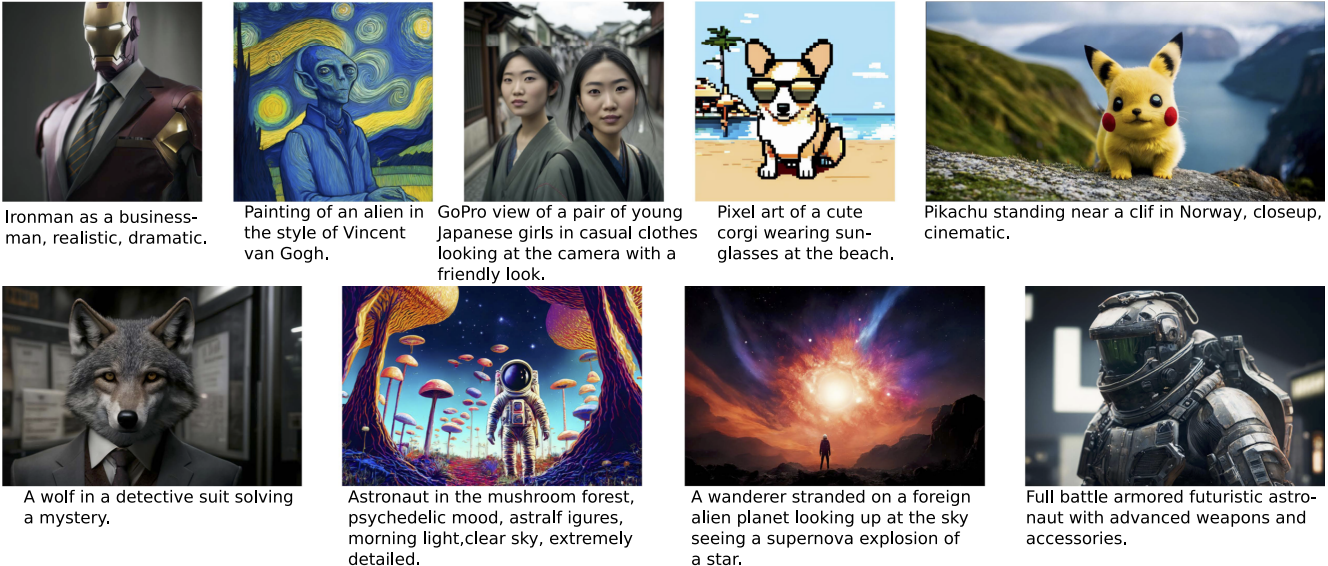

[Würstchen](https://arxiv.org/abs/2306.00637) is a diffusion model, whose text-conditional model works in a highly compressed latent space of images. Why is this important? Compressing data can reduce computational costs for both training and inference by magnitudes. Training on 1024x1024 images, is way more expensive than training at 32x32. Usually, other works make use of a relatively small compression, in the range of 4x - 8x spatial compression. Würstchen takes this to an extreme. Through its novel design, authors achieve a 42x spatial compression. This was unseen before because common methods fail to faithfully reconstruct detailed images after 16x spatial compression. Würstchen employs a two-stage compression (referred below as _Decoder_). The first one is a VQGAN, and the second is a Diffusion Autoencoder (more details can be found in the paper). A third model (referred below as _Prior_) is learned in that highly compressed latent space. This training requires fractions of the compute used for current top-performing models, allowing also cheaper and faster inference.

We will use PyTorch version of Würstchen [model from HuggingFace Hub](https://huggingface.co/warp-ai/wuerstchen).


#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Load the original model](#Load-the-original-model)
    - [Infer the original model](#Infer-the-original-model)
- [Convert the model to OpenVINO IR](#Convert-the-model-to-OpenVINO-IR)
    - [Prior pipeline](#Prior-pipeline)
    - [Decoder pipeline](#Decoder-pipeline)
- [Compiling models](#Compiling-models)
- [Building the pipeline](#Building-the-pipeline)
- [Inference](#Inference)
- [Quantization](#Quantization)
    - [Prepare calibration datasets](#Prepare-calibration-datasets)
    - [Run quantization](#Run-quantization)
    - [Compare model file sizes](#Compare-model-file-sizes)
    - [Compare inference time of the FP16 and INT8 pipelines](#Compare-inference-time-of-the-FP16-and-INT8-pipelines)
- [Interactive inference](#Interactive-inference)



## Prerequisites
[back to top ⬆️](#Table-of-contents:)


In [1]:
import platform

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

%pip install -q  "diffusers>=0.21.0" "torch>=2.1" transformers accelerate gradio "openvino>=2023.2.0" "peft==0.6.2" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q datasets "nncf>=2.7.0"

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path
from collections import namedtuple
import gc

import diffusers
import torch
import matplotlib.pyplot as plt
import gradio as gr
import numpy as np

import openvino as ov

In [3]:
MODELS_DIR = Path("models")
PRIOR_TEXT_ENCODER_PATH = MODELS_DIR / "prior_text_encoder.xml"
PRIOR_PRIOR_PATH = MODELS_DIR / "prior_prior.xml"
DECODER_PATH = MODELS_DIR / "decoder.xml"
TEXT_ENCODER_PATH = MODELS_DIR / "text_encoder.xml"
VQGAN_PATH = MODELS_DIR / "vqgan.xml"

MODELS_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
BaseModelOutputWithPooling = namedtuple("BaseModelOutputWithPooling", "last_hidden_state")
DecoderOutput = namedtuple("DecoderOutput", "sample")

## Load the original model
[back to top ⬆️](#Table-of-contents:)

We use `from_pretrained` method of `diffusers.AutoPipelineForText2Image` to load the pipeline.

In [ ]:
pipeline = diffusers.AutoPipelineForText2Image.from_pretrained("warp-diffusion/wuerstchen")

Loaded model has `WuerstchenCombinedPipeline` type and consists of 2 parts: prior and decoder.

### Infer the original model
[back to top ⬆️](#Table-of-contents:)


In [ ]:
caption = "Anthropomorphic cat dressed as a fire fighter"
negative_prompt = ""
generator = torch.Generator().manual_seed(1)
output = pipeline(
    prompt=caption,
    height=1024,
    width=1024,
    negative_prompt=negative_prompt,
    prior_guidance_scale=4.0,
    decoder_guidance_scale=0.0,
    output_type="pil",
    generator=generator,
).images

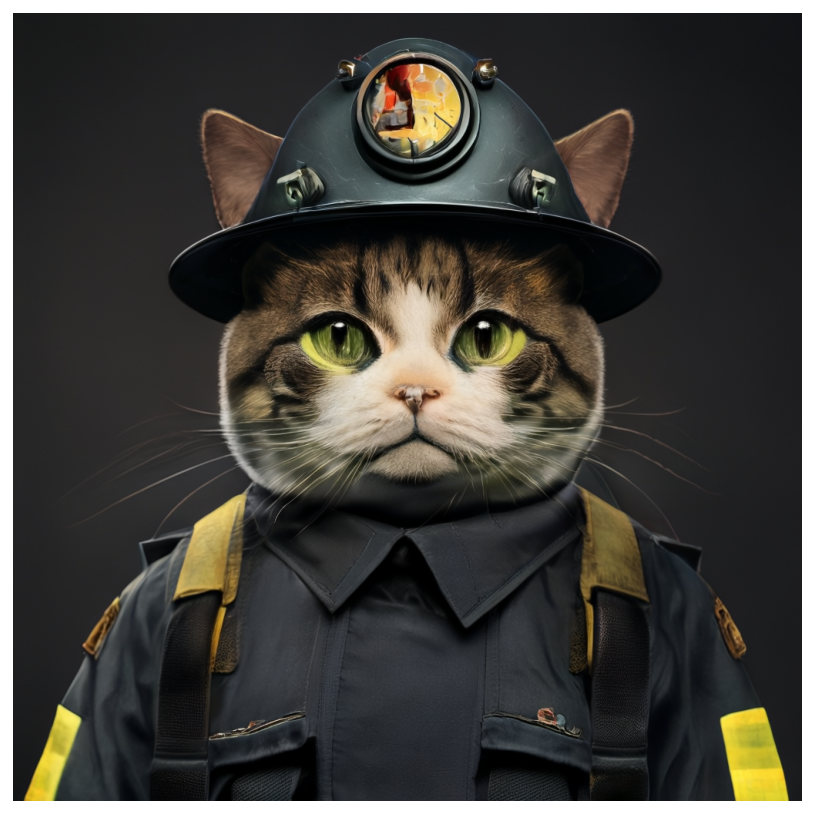

In [7]:
plt.figure(figsize=(8 * len(output), 8), dpi=128)
for i, x in enumerate(output):
    plt.subplot(1, len(output), i + 1)
    plt.imshow(x)
    plt.axis("off")

## Convert the model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

Main model components:
- Prior stage: create low-dimensional latent space representation of the image using text-conditional LDM
- Decoder stage: using representation from Prior Stage, produce a latent image in latent space of higher dimensionality using another LDM and using VQGAN-decoder, decode the latent image to yield a full-resolution output image

The pipeline consists of 2 sub-pipelines: Prior pipeline accessed by `prior_pipe` property, and Decoder Pipeline accessed by `decoder_pipe` property.

In [8]:
# Prior pipeline
pipeline.prior_text_encoder.eval()
pipeline.prior_prior.eval()

# Decoder pipeline
pipeline.decoder.eval()
pipeline.text_encoder.eval()
pipeline.vqgan.eval();

Next, let's define the conversion function for PyTorch modules. We use `ov.convert_model` function to obtain OpenVINO Intermediate Representation object and `ov.save_model` function to save it as XML file.

In [9]:
def convert(model: torch.nn.Module, xml_path: Path, **convert_kwargs):
    if not xml_path.exists():
        converted_model = ov.convert_model(model, **convert_kwargs)
        ov.save_model(converted_model, xml_path, compress_to_fp16=False)
        del converted_model

        # Clean torch jit cache
        torch._C._jit_clear_class_registry()
        torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
        torch.jit._state._clear_class_state()

        gc.collect()

### Prior pipeline
[back to top ⬆️](#Table-of-contents:)

This pipeline consists of text encoder and prior diffusion model. From here, we always use fixed shapes in conversion by using an `input` parameter to generate a less memory-demanding model.

Text encoder model has 2 inputs:
- `input_ids`: vector of tokenized input sentence. Default tokenizer vector length is 77.
- `attention_mask`: vector of same length as `input_ids` describing the attention mask.

In [10]:
convert(
    pipeline.prior_text_encoder,
    PRIOR_TEXT_ENCODER_PATH,
    example_input={
        "input_ids": torch.zeros(1, 77, dtype=torch.int32),
        "attention_mask": torch.zeros(1, 77),
    },
    input={"input_ids": ((1, 77),), "attention_mask": ((1, 77),)},
)
del pipeline.prior_text_encoder
del pipeline.prior_pipe.text_encoder
gc.collect()

2058

Prior model is the canonical unCLIP prior to approximate the image embedding from the text embedding. Like UNet, it has 3 inputs: sample, timestep and encoder hidden states.

In [11]:
convert(
    pipeline.prior_prior,
    PRIOR_PRIOR_PATH,
    example_input=[torch.zeros(2, 16, 24, 24), torch.zeros(2), torch.zeros(2, 77, 1280)],
    input=[((2, 16, 24, 24),), ((2),), ((2, 77, 1280),)],
)
del pipeline.prior_prior
del pipeline.prior_pipe.prior
gc.collect()

0

### Decoder pipeline
[back to top ⬆️](#Table-of-contents:)

Decoder pipeline consists of 3 parts: decoder, text encoder and VQGAN.

Decoder model is the WuerstchenDiffNeXt UNet decoder. Inputs are:
- `x`: sample
- `r`: timestep
- `effnet`: interpolation block
- `clip`: encoder hidden states

In [12]:
convert(
    pipeline.decoder,
    DECODER_PATH,
    example_input={
        "x": torch.zeros(1, 4, 256, 256),
        "r": torch.zeros(1),
        "effnet": torch.zeros(1, 16, 24, 24),
        "clip": torch.zeros(1, 77, 1024),
    },
    input={
        "x": ((1, 4, 256, 256),),
        "r": ((1),),
        "effnet": ((1, 16, 24, 24),),
        "clip": ((1, 77, 1024),),
    },
)
del pipeline.decoder
del pipeline.decoder_pipe.decoder
gc.collect()

0

The main text encoder has the same input parameters and shapes as text encoder in [prior pipeline](#Prior-pipeline).

In [13]:
convert(
    pipeline.text_encoder,
    TEXT_ENCODER_PATH,
    example_input={
        "input_ids": torch.zeros(1, 77, dtype=torch.int32),
        "attention_mask": torch.zeros(1, 77),
    },
    input={"input_ids": ((1, 77),), "attention_mask": ((1, 77),)},
)
del pipeline.text_encoder
del pipeline.decoder_pipe.text_encoder
gc.collect()

0

Pipeline uses VQGAN model `decode` method to get the full-size output image. Here we create the wrapper module for decoding part only. Our decoder takes as input 4x256x256 latent image.

In [14]:
class VqganDecoderWrapper(torch.nn.Module):
    def __init__(self, vqgan):
        super().__init__()
        self.vqgan = vqgan

    def forward(self, h):
        return self.vqgan.decode(h)

In [15]:
convert(
    VqganDecoderWrapper(pipeline.vqgan),
    VQGAN_PATH,
    example_input=torch.zeros(1, 4, 256, 256),
    input=(1, 4, 256, 256),
)
del pipeline.decoder_pipe.vqgan
gc.collect()

0

## Compiling models
[back to top ⬆️](#Table-of-contents:)


In [16]:
core = ov.Core()

Select device from dropdown list for running inference using OpenVINO.

In [17]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=4, options=('CPU', 'GPU.0', 'GPU.1', 'GPU.2', 'AUTO'), value='AUTO')

In [18]:
ov_prior_text_encoder = core.compile_model(PRIOR_TEXT_ENCODER_PATH, device.value)

In [19]:
ov_prior_prior = core.compile_model(PRIOR_PRIOR_PATH, device.value)

In [20]:
ov_decoder = core.compile_model(DECODER_PATH, device.value)

In [21]:
ov_text_encoder = core.compile_model(TEXT_ENCODER_PATH, device.value)

In [22]:
ov_vqgan = core.compile_model(VQGAN_PATH, device.value)

## Building the pipeline
[back to top ⬆️](#Table-of-contents:)

Let's create callable wrapper classes for compiled models to allow interaction with original `WuerstchenCombinedPipeline` class. Note that all of wrapper classes return `torch.Tensor`s instead of `np.array`s.

In [23]:
class TextEncoderWrapper:
    dtype = torch.float32  # accessed in the original workflow

    def __init__(self, text_encoder):
        self.text_encoder = text_encoder

    def __call__(self, input_ids, attention_mask):
        output = self.text_encoder({"input_ids": input_ids, "attention_mask": attention_mask})[
            "last_hidden_state"
        ]
        output = torch.tensor(output)
        return BaseModelOutputWithPooling(output)

In [24]:
class PriorPriorWrapper:
    config = namedtuple("PriorPriorWrapperConfig", "c_in")(16)  # accessed in the original workflow

    def __init__(self, prior):
        self.prior = prior

    def __call__(self, x, r, c):
        output = self.prior([x, r, c])[0]
        return torch.tensor(output)

In [25]:
class DecoderWrapper:
    dtype = torch.float32  # accessed in the original workflow

    def __init__(self, decoder):
        self.decoder = decoder

    def __call__(self, x, r, effnet, clip):
        output = self.decoder({"x": x, "r": r, "effnet": effnet, "clip": clip})[0]
        output = torch.tensor(output)
        return output

In [26]:
class VqganWrapper:
    config = namedtuple("VqganWrapperConfig", "scale_factor")(0.3764)  # accessed in the original workflow

    def __init__(self, vqgan):
        self.vqgan = vqgan

    def decode(self, h):
        output = self.vqgan(h)[0]
        output = torch.tensor(output)
        return DecoderOutput(output)

And insert wrappers instances in the pipeline:

In [27]:
pipeline.prior_pipe.text_encoder = TextEncoderWrapper(ov_prior_text_encoder)
pipeline.prior_pipe.prior = PriorPriorWrapper(ov_prior_prior)

pipeline.decoder_pipe.decoder = DecoderWrapper(ov_decoder)
pipeline.decoder_pipe.text_encoder = TextEncoderWrapper(ov_text_encoder)
pipeline.decoder_pipe.vqgan = VqganWrapper(ov_vqgan)

## Inference
[back to top ⬆️](#Table-of-contents:)


In [ ]:
caption = "Anthropomorphic cat dressed as a fire fighter"
negative_prompt = ""
generator = torch.Generator().manual_seed(1)

output = pipeline(
    prompt=caption,
    height=1024,
    width=1024,
    negative_prompt=negative_prompt,
    prior_guidance_scale=4.0,
    decoder_guidance_scale=0.0,
    output_type="pil",
    generator=generator,
).images

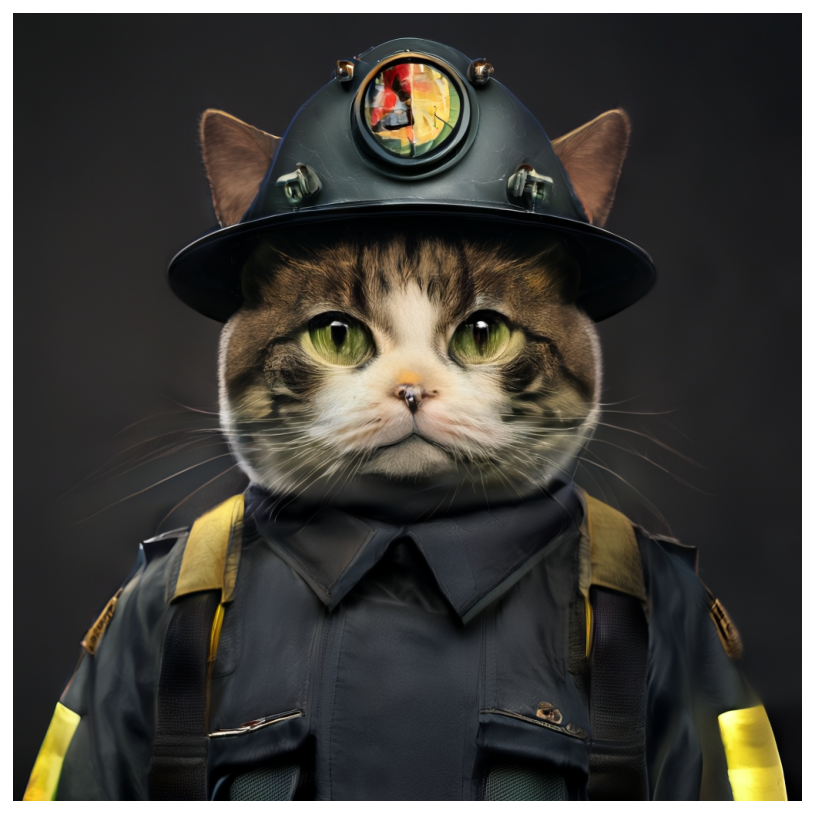

In [29]:
plt.figure(figsize=(8 * len(output), 8), dpi=128)
for i, x in enumerate(output):
    plt.subplot(1, len(output), i + 1)
    plt.imshow(x)
    plt.axis("off")

## Quantization
[back to top ⬆️](#Table-of-contents:)

[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.

According to `WuerstchenPriorPipeline` structure, prior model is used in the cycle repeating inference on each diffusion step, while text encoder takes part only once, and in the `WuerstchenDecoderPipeline`, the decoder model is used in a loop, and other pipeline components are inferred only once. That is why computation cost and speed of prior and decoder models become the critical path in the pipeline. Quantizing the rest of the pipeline does not significantly improve inference performance but can lead to a substantial degradation of accuracy.

The optimization process contains the following steps:

1. Create a calibration dataset for quantization.
2. Run `nncf.quantize()` to obtain quantized model.
3. Save the `INT8` model using `openvino.save_model()` function.

Please select below whether you would like to run quantization to improve model inference speed.

In [ ]:
to_quantize = widgets.Checkbox(
    value=True,
    description='Quantization',
    disabled=False,
)

to_quantize

Let's load `skip magic` extension to skip quantization if `to_quantize` is not selected

In [ ]:
# Fetch `skip_kernel_extension` module
import urllib.request
urllib.request.urlretrieve(
    url='https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/utils/skip_kernel_extension.py',
    filename='skip_kernel_extension.py'
)

int8_pipeline = None

%load_ext skip_kernel_extension

### Prepare calibration datasets
[back to top ⬆️](#Table-of-contents:)

We use a portion of [conceptual_captions](https://huggingface.co/datasets/conceptual_captions) dataset from Hugging Face as calibration data.
To collect intermediate model inputs for calibration we should customize `CompiledModel`.

In [32]:
%%skip not $to_quantize.value

class CompiledModelDecorator(ov.CompiledModel):
    def __init__(self, compiled_model):
        super().__init__(compiled_model)
        self.data_cache = []

    def __call__(self, *args, **kwargs):
        self.data_cache.append(*args)
        return super().__call__(*args, **kwargs)

In [33]:
%%skip not $to_quantize.value

import datasets
from tqdm.notebook import tqdm
from transformers import set_seed

set_seed(1)

def collect_calibration_data(pipeline, subset_size):
    pipeline.set_progress_bar_config(disable=True)

    original_prior = pipeline.prior_pipe.prior.prior
    original_decoder = pipeline.decoder_pipe.decoder.decoder
    pipeline.prior_pipe.prior.prior = CompiledModelDecorator(original_prior)
    pipeline.decoder_pipe.decoder.decoder = CompiledModelDecorator(original_decoder)

    dataset = datasets.load_dataset("conceptual_captions", split="train").shuffle(seed=42)
    pbar = tqdm(total=subset_size)
    diff = 0
    for batch in dataset:
        prompt = batch["caption"]
        if len(prompt) > pipeline.tokenizer.model_max_length:
            continue
        _ = pipeline(
            prompt=prompt,
            height=1024,
            width=1024,
            negative_prompt="",
            prior_guidance_scale=4.0,
            decoder_guidance_scale=0.0,
            output_type="pil",
        )
        collected_subset_size = len(pipeline.prior_pipe.prior.prior.data_cache)
        if collected_subset_size >= subset_size:
            pbar.update(subset_size - pbar.n)
            break
        pbar.update(collected_subset_size - diff)
        diff = collected_subset_size

    prior_calibration_dataset = pipeline.prior_pipe.prior.prior.data_cache
    decoder_calibration_dataset = pipeline.decoder_pipe.decoder.decoder.data_cache
    pipeline.prior_pipe.prior.prior = original_prior
    pipeline.decoder_pipe.decoder.decoder = original_decoder
    pipeline.set_progress_bar_config(disable=False)
    return prior_calibration_dataset, decoder_calibration_dataset

In [34]:
%%skip not $to_quantize.value

PRIOR_PRIOR_INT8_PATH = MODELS_DIR / "prior_prior_int8.xml"
DECODER_INT8_PATH = MODELS_DIR / "decoder_int8.xml"

if not (PRIOR_PRIOR_INT8_PATH.exists() and DECODER_INT8_PATH.exists()):
    subset_size = 300
    prior_calibration_dataset, decoder_calibration_dataset = collect_calibration_data(pipeline, subset_size=subset_size)

### Run quantization
[back to top ⬆️](#Table-of-contents:)

Create a quantized model from the pre-trained converted OpenVINO model. `BiasCorrection` algorithm is disabled due to minimal accuracy improvement in Würstchen model and increased quantization time. The prior and decoder models are transformer-based backbone networks, we use `model_type=nncf.ModelType.TRANSFORMER` to specify additional transformer patterns in the model. It preserves accuracy after NNCF PTQ by retaining several accuracy-sensitive layers in FP16 precision.

The quantization of the first and last `Convolution` layers in the prior model dramatically impacts the generation results according to our experiments. We recommend using `IgnoredScope` to keep them in FP16 precision.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

In [36]:
%%skip not $to_quantize.value

import nncf
from nncf.scopes import IgnoredScope

if not PRIOR_PRIOR_INT8_PATH.exists():
    prior_model = core.read_model(PRIOR_PRIOR_PATH)
    quantized_prior_prior = nncf.quantize(
        model=prior_model,
        subset_size=subset_size,
        calibration_dataset=nncf.Dataset(prior_calibration_dataset),
        model_type=nncf.ModelType.TRANSFORMER,
        ignored_scope=IgnoredScope(names=[
            "__module.projection/aten::_convolution/Convolution",
            "__module.out.1/aten::_convolution/Convolution"
        ]),
        advanced_parameters=nncf.AdvancedQuantizationParameters(
            disable_bias_correction=True
        )
    )
    ov.save_model(quantized_prior_prior, PRIOR_PRIOR_INT8_PATH)

In [37]:
%%skip not $to_quantize.value

if not DECODER_INT8_PATH.exists():
    decoder_model = core.read_model(DECODER_PATH)
    quantized_decoder = nncf.quantize(
        model=decoder_model,
        calibration_dataset=nncf.Dataset(decoder_calibration_dataset),
        subset_size=len(decoder_calibration_dataset),
        model_type=nncf.ModelType.TRANSFORMER,
        advanced_parameters=nncf.AdvancedQuantizationParameters(
            disable_bias_correction=True
        )
    )
    ov.save_model(quantized_decoder, DECODER_INT8_PATH)

Let's compare the images generated by the original and optimized pipelines.

In [38]:
%%skip not $to_quantize.value

import matplotlib.pyplot as plt
from PIL import Image

def visualize_results(orig_img:Image.Image, optimized_img:Image.Image):
    """
    Helper function for results visualization

    Parameters:
       orig_img (Image.Image): generated image using FP16 models
       optimized_img (Image.Image): generated image using quantized models
    Returns:
       fig (matplotlib.pyplot.Figure): matplotlib generated figure contains drawing result
    """
    orig_title = "FP16 pipeline"
    control_title = "INT8 pipeline"
    figsize = (20, 20)
    fig, axs = plt.subplots(1, 2, figsize=figsize, sharex='all', sharey='all')
    list_axes = list(axs.flat)
    for a in list_axes:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.grid(False)
    list_axes[0].imshow(np.array(orig_img))
    list_axes[1].imshow(np.array(optimized_img))
    list_axes[0].set_title(orig_title, fontsize=15)
    list_axes[1].set_title(control_title, fontsize=15)

    fig.subplots_adjust(wspace=0.01, hspace=0.01)
    fig.tight_layout()
    return fig

In [ ]:
%%skip not $to_quantize.value

caption = "Anthropomorphic cat dressed as a fire fighter"
negative_prompt = ""

int8_pipeline = diffusers.AutoPipelineForText2Image.from_pretrained("warp-diffusion/wuerstchen")

int8_prior_prior = core.compile_model(PRIOR_PRIOR_INT8_PATH)
int8_pipeline.prior_pipe.prior = PriorPriorWrapper(int8_prior_prior)

int8_decoder = core.compile_model(DECODER_INT8_PATH)
int8_pipeline.decoder_pipe.decoder = DecoderWrapper(int8_decoder)

int8_pipeline.prior_pipe.text_encoder = TextEncoderWrapper(ov_prior_text_encoder)
int8_pipeline.decoder_pipe.text_encoder = TextEncoderWrapper(ov_text_encoder)
int8_pipeline.decoder_pipe.vqgan = VqganWrapper(ov_vqgan)

In [ ]:
%%skip not $to_quantize.value

generator = torch.Generator().manual_seed(1)
int8_output = int8_pipeline(
    prompt=caption,
    height=1024,
    width=1024,
    negative_prompt=negative_prompt,
    prior_guidance_scale=4.0,
    decoder_guidance_scale=0.0,
    output_type="pil",
    generator=generator,
).images

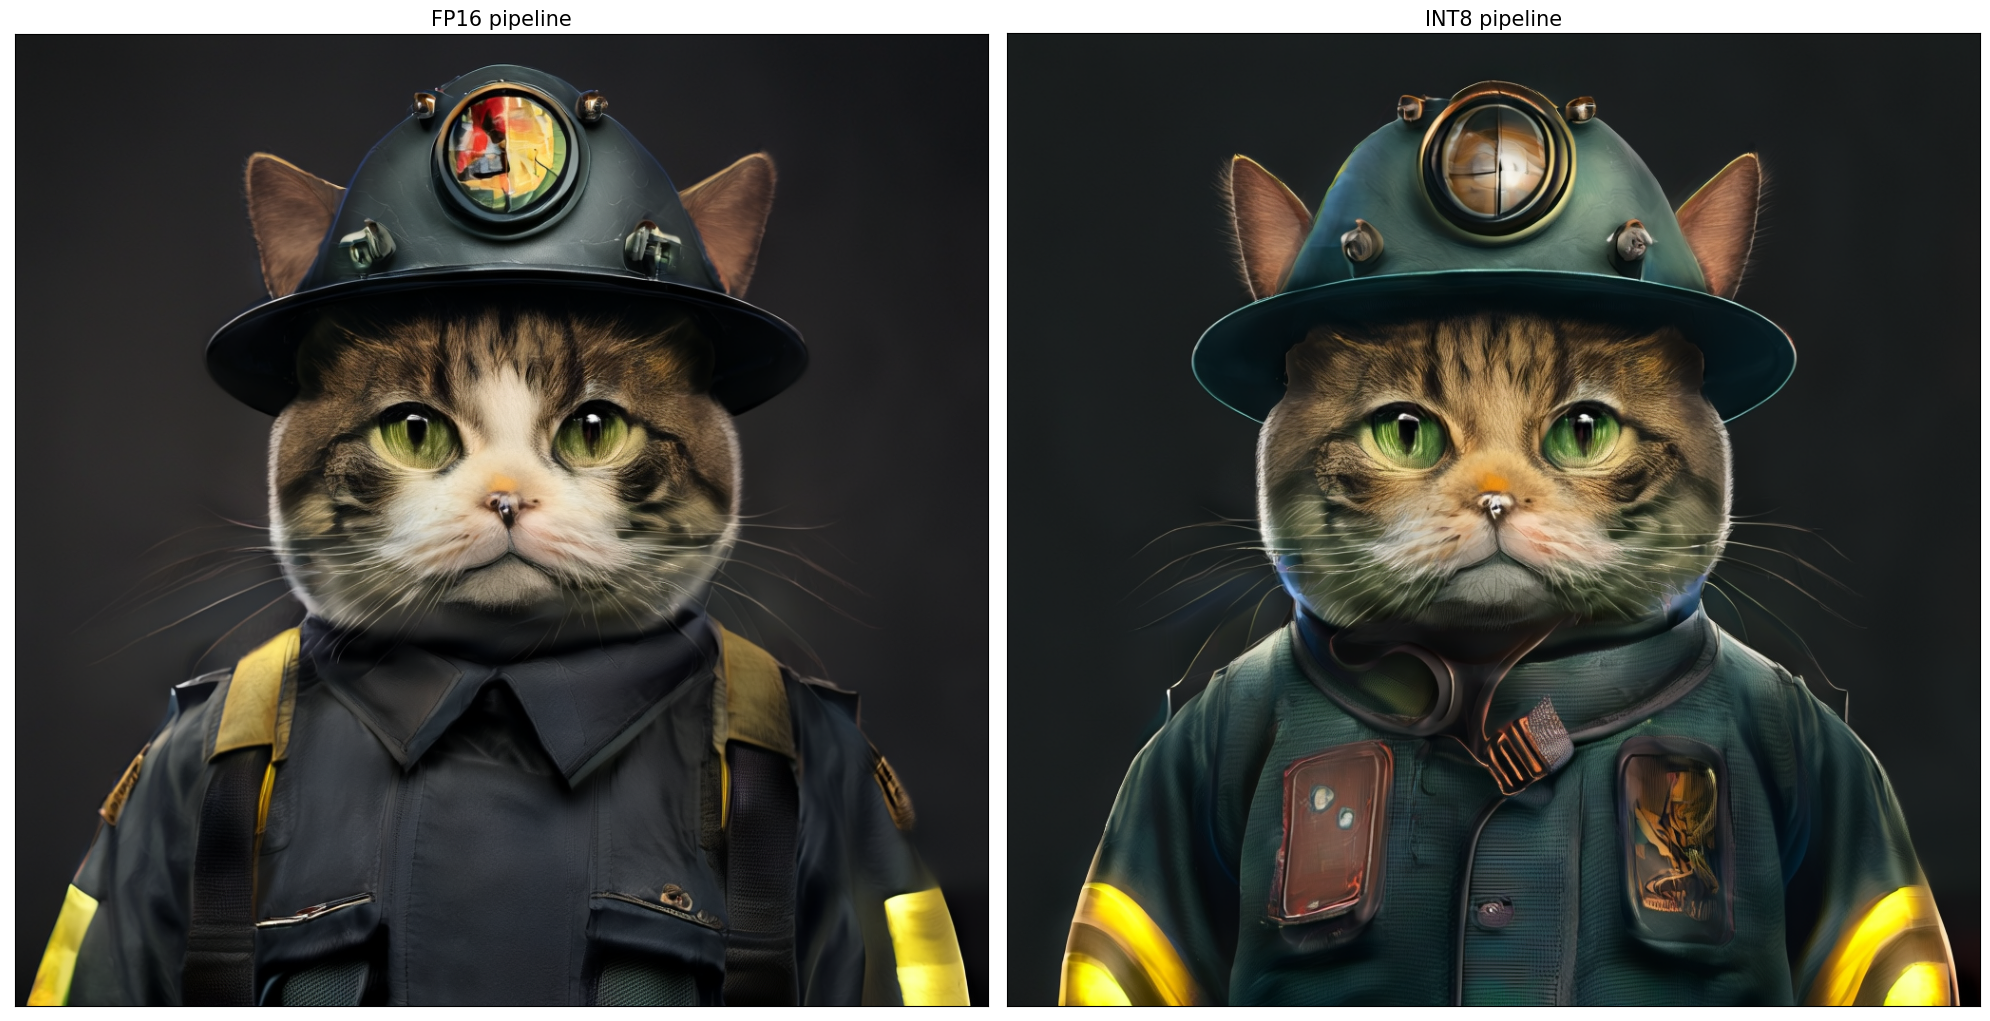

In [42]:
%%skip not $to_quantize.value

fig = visualize_results(output[0], int8_output[0])

### Compare model file sizes
[back to top ⬆️](#Table-of-contents:)

In [43]:
%%skip not $to_quantize.value

fp16_ir_model_size = PRIOR_PRIOR_PATH.with_suffix(".bin").stat().st_size / 2**20
quantized_model_size = PRIOR_PRIOR_INT8_PATH.with_suffix(".bin").stat().st_size / 2**20

print(f"FP16 Prior size: {fp16_ir_model_size:.2f} MB")
print(f"INT8 Prior size: {quantized_model_size:.2f} MB")
print(f"Prior compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

FP16 Prior size: 3790.42 MB
INT8 Prior size: 951.03 MB
Prior compression rate: 3.986


In [44]:
%%skip not $to_quantize.value

fp16_ir_model_size = DECODER_PATH.with_suffix(".bin").stat().st_size / 2**20
quantized_model_size = DECODER_INT8_PATH.with_suffix(".bin").stat().st_size / 2**20

print(f"FP16 Decoder size: {fp16_ir_model_size:.2f} MB")
print(f"INT8 Decoder size: {quantized_model_size:.2f} MB")
print(f"Decoder compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

FP16 Decoder size: 4025.90 MB
INT8 Decoder size: 1010.20 MB
Decoder compression rate: 3.985


### Compare inference time of the FP16 and INT8 pipelines
[back to top ⬆️](#Table-of-contents:)

To measure the inference performance of the `FP16` and `INT8` pipelines, we use mean inference time on 3 samples.

> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications.

In [45]:
%%skip not $to_quantize.value

import time

def calculate_inference_time(pipeline):
    inference_time = []
    pipeline.set_progress_bar_config(disable=True)
    caption = "Anthropomorphic cat dressed as a fire fighter"
    for i in range(3):
        start = time.perf_counter()
        _ = pipeline(
            prompt=caption,
            height=1024,
            width=1024,
            prior_guidance_scale=4.0,
            decoder_guidance_scale=0.0,
            output_type="pil",
        )
        end = time.perf_counter()
        delta = end - start
        inference_time.append(delta)
    pipeline.set_progress_bar_config(disable=False)
    return np.mean(inference_time)

In [46]:
%%skip not $to_quantize.value

fp_latency = calculate_inference_time(pipeline)
print(f"FP16 pipeline: {fp_latency:.3f} seconds")
int8_latency = calculate_inference_time(int8_pipeline)
print(f"INT8 pipeline: {int8_latency:.3f} seconds")
print(f"Performance speed up: {fp_latency / int8_latency:.3f}")

FP16 pipeline: 199.484 seconds
INT8 pipeline: 78.734 seconds
Performance speed up: 2.534


## Interactive inference
[back to top ⬆️](#Table-of-contents:)

Please select below whether you would like to use the quantized model to launch the interactive demo.

In [ ]:
quantized_model_present = int8_pipeline is not None

use_quantized_model = widgets.Checkbox(
    value=quantized_model_present,
    description='Use quantized model',
    disabled=not quantized_model_present,
)

use_quantized_model

In [66]:
pipe = int8_pipeline if use_quantized_model.value else pipeline

def generate(caption, negative_prompt, prior_guidance_scale, seed):
    generator = torch.Generator().manual_seed(seed)
    image = pipe(
        prompt=caption,
        height=1024,
        width=1024,
        negative_prompt=negative_prompt,
        prior_num_inference_steps=30,
        prior_guidance_scale=prior_guidance_scale,
        generator=generator,
        output_type="pil",
    ).images[0]
    return image

In [ ]:
demo = gr.Interface(
    generate,
    [
        gr.Textbox(label="Caption"),
        gr.Textbox(label="Negative prompt"),
        gr.Slider(2, 20, step=1, label="Prior guidance scale"),
        gr.Slider(0, np.iinfo(np.int32).max, label="Seed")
    ],
    "image",
    examples=[["Anthropomorphic cat dressed as a firefighter", "", 4, 0]],
    allow_flagging="never",
)
try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(debug=True, share=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/